# COMUNET

**Language:** R

**Paper:** Solovey, M. and A. Scialdone, COMUNET: a tool to explore and visualize intercellular communication. Bioinformatics, 2020. 36(15): p. 4296-4300.

**Code Resource:** https://github.com/ScialdoneLab/COMUNET

**Claiming:** Inference of intercellular signaling networks (ligand-receptor) in form of clusters, and signaling change between two datasets

**Method:** Calculate pairwise dissimilarities between the layers in a multiple network, which represents the pairs of interacting partners

**Database:** NULL (other tools' L-R analysis result data required)


## Input
1. a set of weight matrices, one for each pair of interacting partners, with information of the weight of each cell types
2. a pattern of interest: a binary adjacency matrix, 1 indicating the presence of an edge and 0 the absence

Here, we will use the output and database generated by CellPhoneDB from https://github.com/ScialdoneLab/COMUNET

Download link: https://zenodo.org/record/5036232#.YNmQuToRVGM

## Installation

In [ ]:
devtools::install_github("ScialdoneLab/COMUNET/COMUNET")

### Preparation

In [1]:
library(COMUNET)
options(stringsAsFactors = F)

Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: dynamicTreeCut

Loading required package: ggplot2

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading 

In [10]:
# Read in data
complex_input <- read.csv("complex_input.csv")
complex_input$complex_name <- gsub("_" ," " ,complex_input$complex_name)
gene_input <- read.csv("gene_input.csv")
# read in CellPhoneDB output
CellPhoneDB_output <- read.csv("cpdb_output/significant_means.txt",sep = "\t" ,check.names = F)
# delete duplicates
CellPhoneDB_output <- CellPhoneDB_output[!duplicated(CellPhoneDB_output$interacting_pair),]
# add row names (interacting pairs)
rownames(CellPhoneDB_output) <- CellPhoneDB_output$interacting_pair
# transform receptor colomn into boolean
CellPhoneDB_output$receptor_a  <- sapply(CellPhoneDB_output$receptor_a
                                         ,function(i){
                                           if(i == "True") T else F
                                         })
CellPhoneDB_output$receptor_b  <- sapply(CellPhoneDB_output$receptor_b
                                         ,function(i){
                                           if(i == "True") T else F
                                         })
head(CellPhoneDB_output)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,⋯,emVE|EPI,emVE|Mes,emVE|TE,emVE|emVE,emVE|exVE,exVE|EPI,exVE|Mes,exVE|TE,exVE|emVE,exVE|exVE
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FZD6_WNT5A,CPI-SS082AD7B6A,FZD6_WNT5A,simple:O60353,simple:P41221,FZD6,WNT5A,True,TRUE,FALSE,curated,⋯,NA,0.438,NA,NA,NA,NA,NA,NA,NA,NA
NRG1_NETO2,CPI-SS0E075E5AF,NRG1_NETO2,simple:Q02297,simple:Q8NC67,NRG1,NETO2,True,TRUE,TRUE,InnateDB-All,⋯,NA,NA,NA,NA,NA,NA,0.231,NA,NA,NA
EPHB2_EFNB1,CPI-SS0111AAD26,EPHB2_EFNB1,simple:P29323,simple:P98172,EPHB2,EFNB1,False,TRUE,FALSE,curated,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
EPHB2_EFNB3,CPI-SS0DA366C78,EPHB2_EFNB3,simple:P29323,simple:Q15768,EPHB2,EFNB3,False,TRUE,TRUE,curated,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
WNT2_FZD4,CPI-SS0C2561156,WNT2_FZD4,simple:P09544,simple:Q9ULV1,WNT2,FZD4,True,FALSE,TRUE,curated,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
VEGFA_EPHB2,CPI-SS02371A6D6,VEGFA_EPHB2,simple:P15692,simple:P29323,VEGFA,EPHB2,True,FALSE,TRUE,I2D,⋯,NA,NA,NA,NA,NA,0.471,NA,NA,NA,NA


### Convert CellPhoneDB output
In this step, we will transform the CellPhoneDB weight matrix into a COMUNET format. The CellPhoneDB weight matrix (significant_means.txt) contains ligand-receptor pairs in the rows and all pairs of cell types in the columns. COMUNET transforms it into a stack of weight matrices (i.e. weight array), one weight matrix per ligand-receptor pair.

In [13]:
interactions <- convert_CellPhoneDB_output(CellPhoneDB_output = CellPhoneDB_output
                                           ,complex_input = complex_input
                                           ,gene_input = gene_input)
str(interactions)

List of 3
 $ weight_array           : num [1:5, 1:5, 1:162] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:5] "EPI" "Mes" "TE" "emVE" ...
  .. ..$ : chr [1:5] "EPI" "Mes" "TE" "emVE" ...
  .. ..$ : chr [1:162] "WNT5A:FZD6" "NRG1:NETO2" "EFNB1:EPHB2" "EPHB2:EFNB3" ...
 $ ligand_receptor_pair_df:'data.frame':	162 obs. of  5 variables:
  ..$ pair                        : chr [1:162] "WNT5A:FZD6" "NRG1:NETO2" "EFNB1:EPHB2" "EPHB2:EFNB3" ...
  ..$ ligand                      : chr [1:162] "WNT5A" "NRG1" "EFNB1" "EPHB2" ...
  ..$ ligand_complex_composition  : chr [1:162] "WNT5A" "NRG1" "EFNB1" "EPHB2" ...
  ..$ receptor                    : chr [1:162] "FZD6" "NETO2" "EPHB2" "EFNB3" ...
  ..$ receptor_complex_composition: chr [1:162] "FZD6" "NETO2" "EPHB2" "EFNB3" ...
 $ nodes                  : chr [1:5] "EPI" "Mes" "TE" "emVE" ...


### Clustering of interacting partners
In this analysis, we want to find out, whether there are ligand-receptor pairs that are used for communication in a similar way (i.e. by same cell types and with same intensity). For this, COMUNET will make a pairwise comparison of the communication graphs of all ligand-receptor pairs and put similar communication graphs into clusters.

 ..cutHeight not given, setting it to 0.986  ===>  99% of the (truncated) height range in dendro.
 ..done.


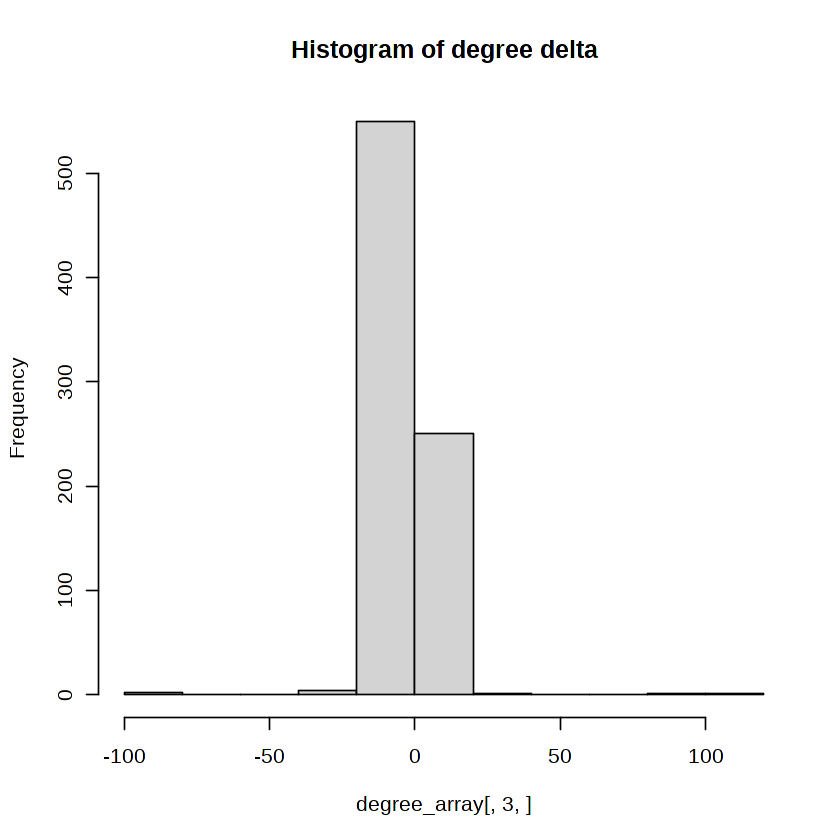

[1] "Warning: some graphs are not assigned to any cluster"
[1] "We have 8 clusters"


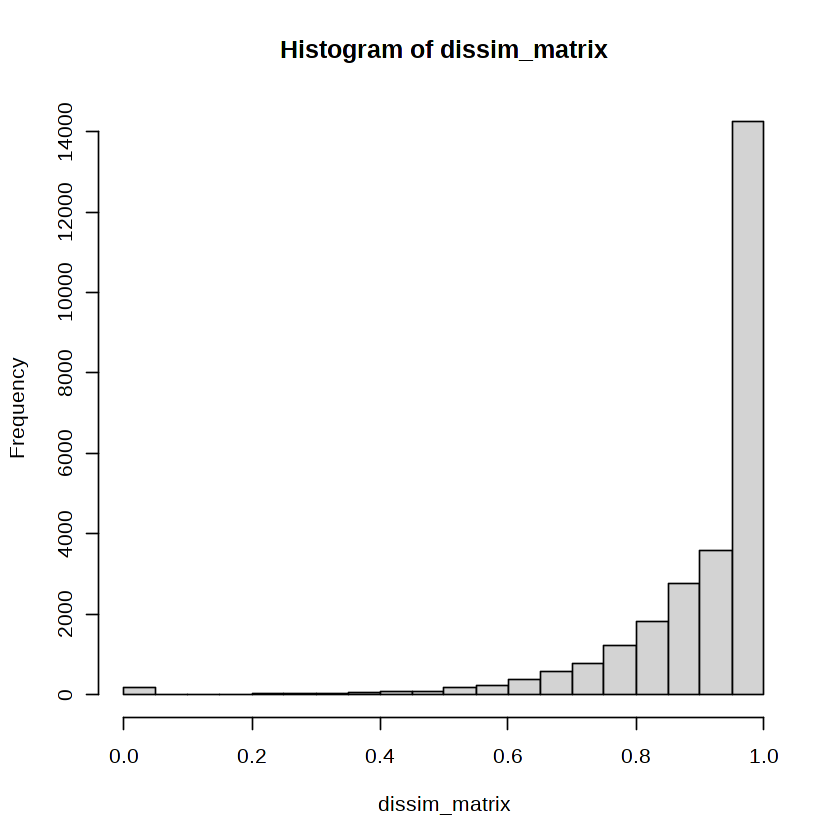

In [14]:
lrp_clusters <- lrp_clustering(weight_array = interactions$weight_array
                               ,ligand_receptor_pair_df = interactions$ligand_receptor_pair_df
                               ,nodes = interactions$nodes)

In [15]:
print(str(lrp_clusters))

List of 3
 $ dissim_matrix          : num [1:162, 1:162] 0 1 1 1 1 1 1 1 1 1 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:162] "WNT5A:FZD6" "NRG1:NETO2" "EFNB1:EPHB2" "EPHB2:EFNB3" ...
  .. ..$ : chr [1:162] "WNT5A:FZD6" "NRG1:NETO2" "EFNB1:EPHB2" "EPHB2:EFNB3" ...
 $ clusters               : Named num [1:162] 4 2 2 1 4 2 1 5 3 1 ...
  ..- attr(*, "names")= chr [1:162] "WNT5A:FZD6" "NRG1:NETO2" "EFNB1:EPHB2" "EPHB2:EFNB3" ...
 $ weight_array_by_cluster: num [1:5, 1:5, 1:8] 0.0973 0.2163 0.3269 0.0455 0.0264 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:5] "EPI" "Mes" "TE" "emVE" ...
  .. ..$ : chr [1:5] "EPI" "Mes" "TE" "emVE" ...
  .. ..$ : chr [1:8] "cluster 1" "cluster 2" "cluster 3" "cluster 4" ...
NULL


### Visualization

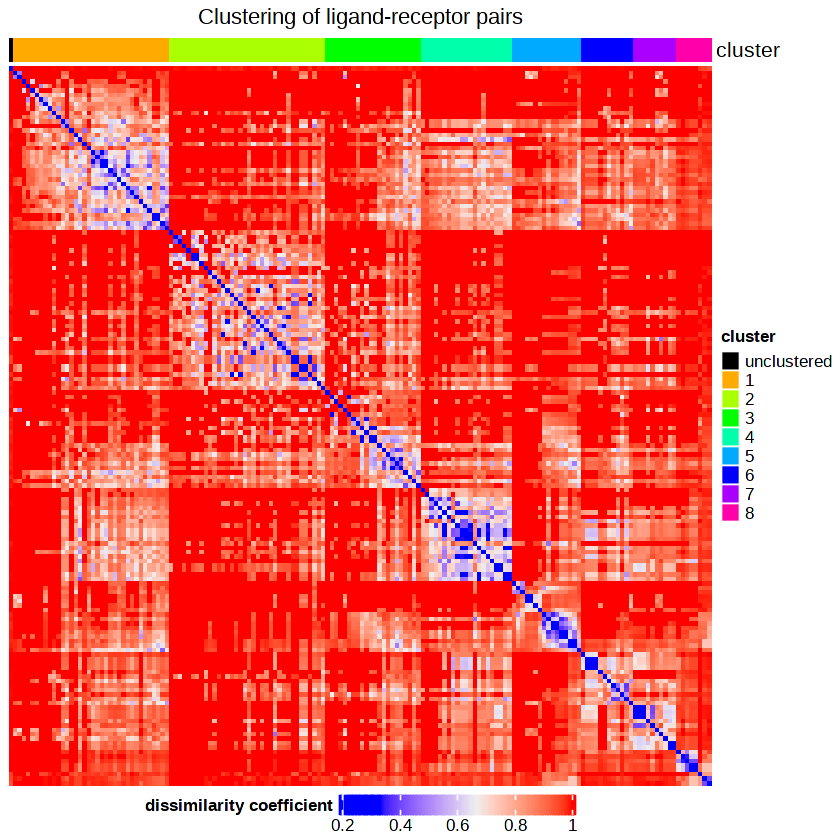

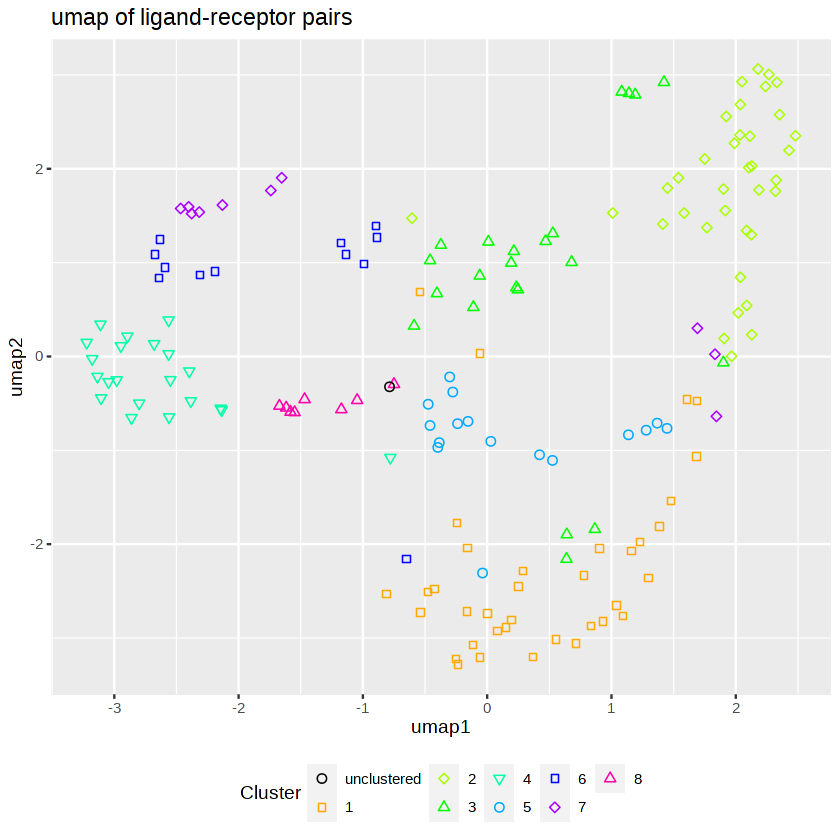

In [16]:
plot_cluster_heatmap(dissim_matrix = lrp_clusters$dissim_matrix
                     ,lrp_clusters = lrp_clusters$clusters)
plot_cluster_UMAP(ligand_receptor_pair_df = interactions$ligand_receptor_pair_df
                  ,dissim_matrix = lrp_clusters$dissim_matrix
                  ,lrp_clusters = lrp_clusters$clusters)

We can as well plot the average communication pattern of the first three clusters

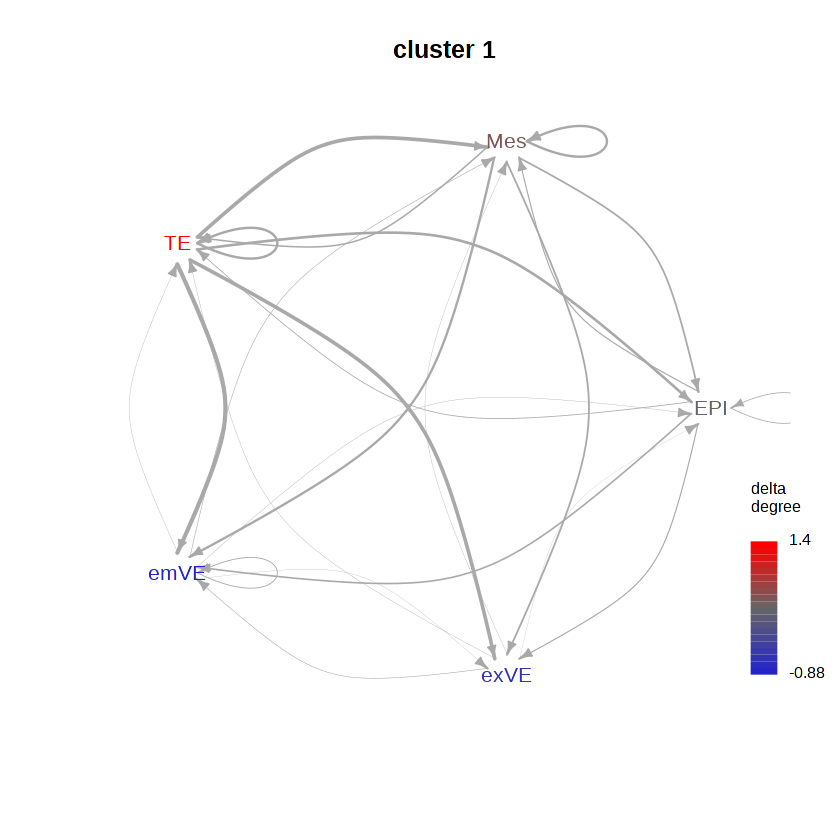

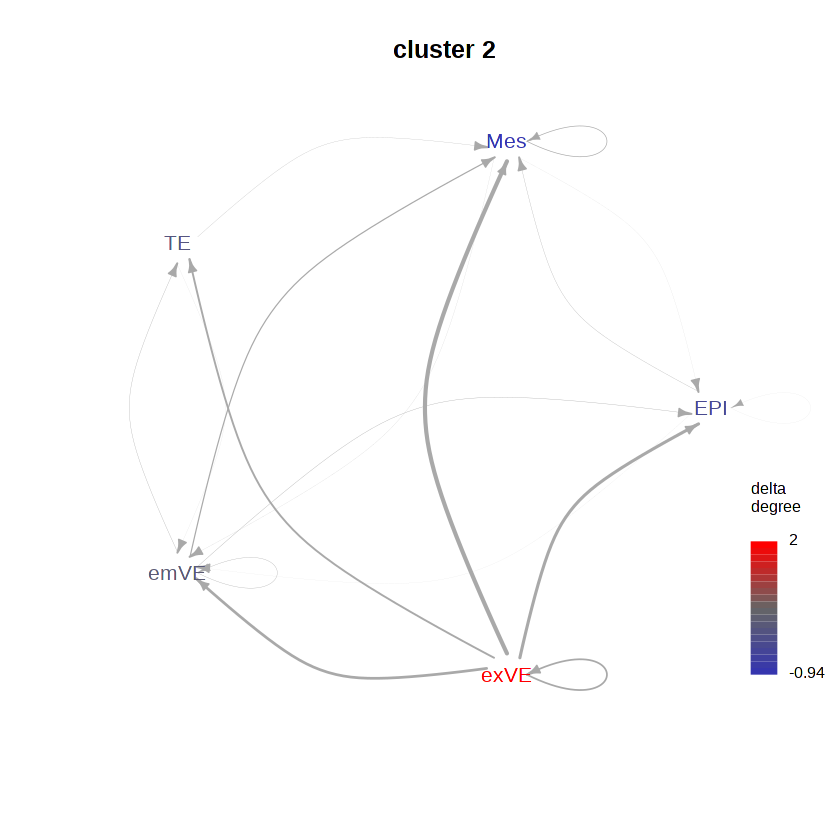

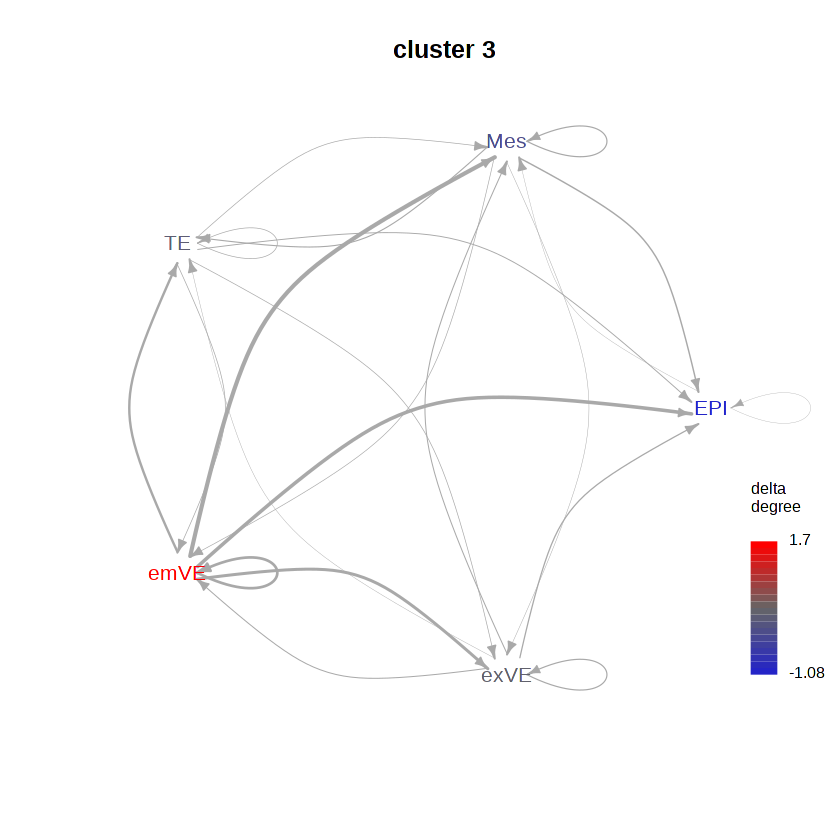

In [17]:
for(clusterNr in c(1:3)){
  cluster  <-  paste("cluster"
                     ,clusterNr)
  plot_communication_graph(LRP = cluster
                           ,weight_array = lrp_clusters$weight_array_by_cluster[,,cluster]
                           ,ligand_receptor_pair_df = interactions$ligand_receptor_pair_df
                           ,nodes = interactions$nodes
                           ,is_cluster = T
  )
}

As the last step, let us inspect, which ligand-receptor pairs are present in the (first three) clusters.

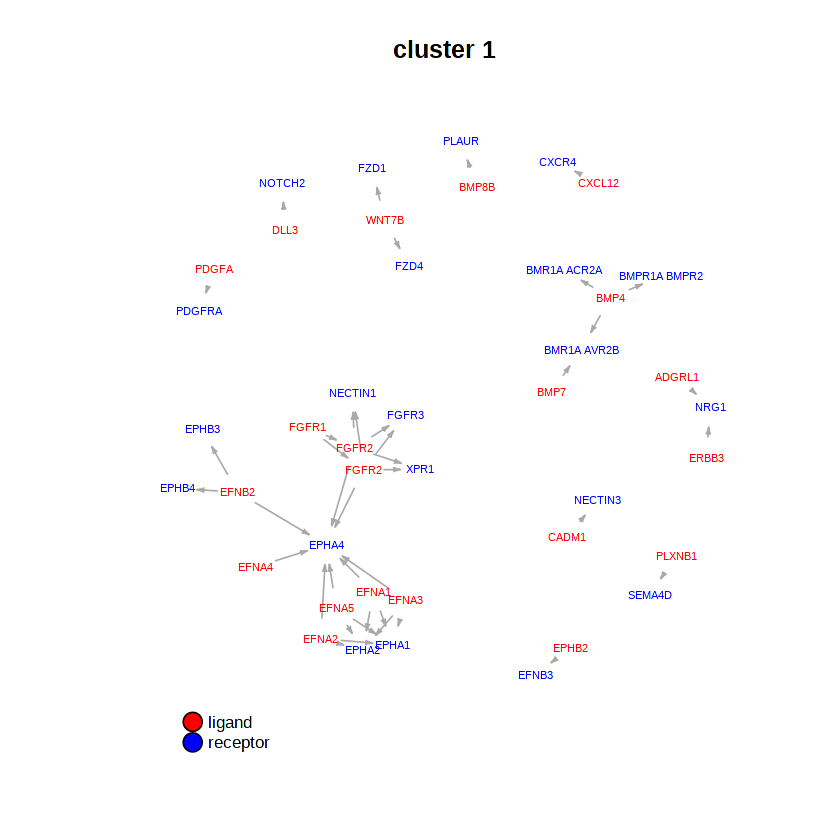

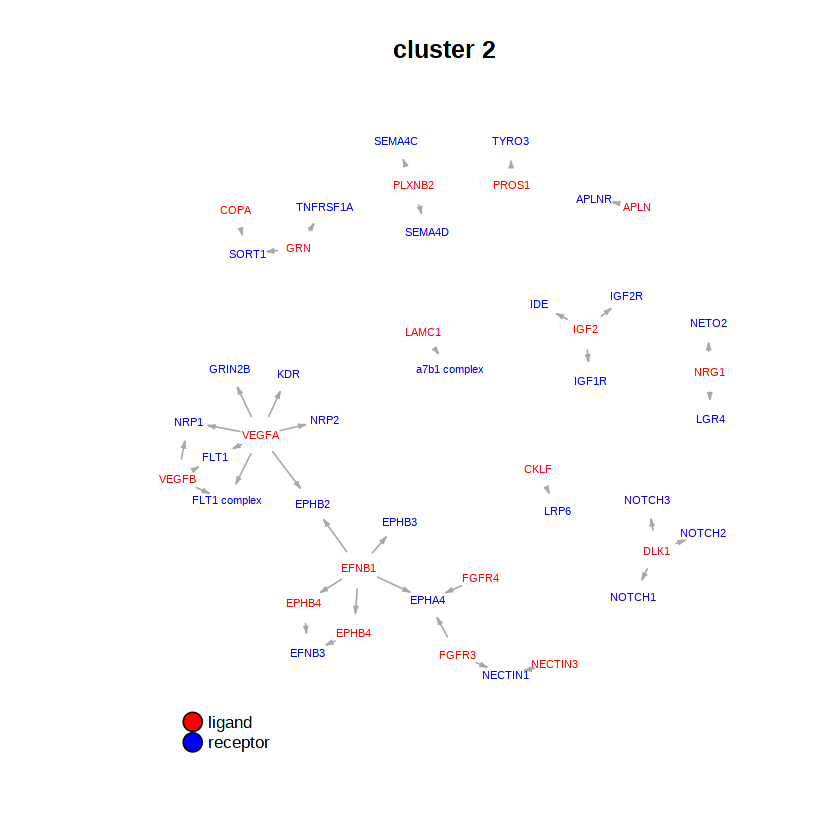

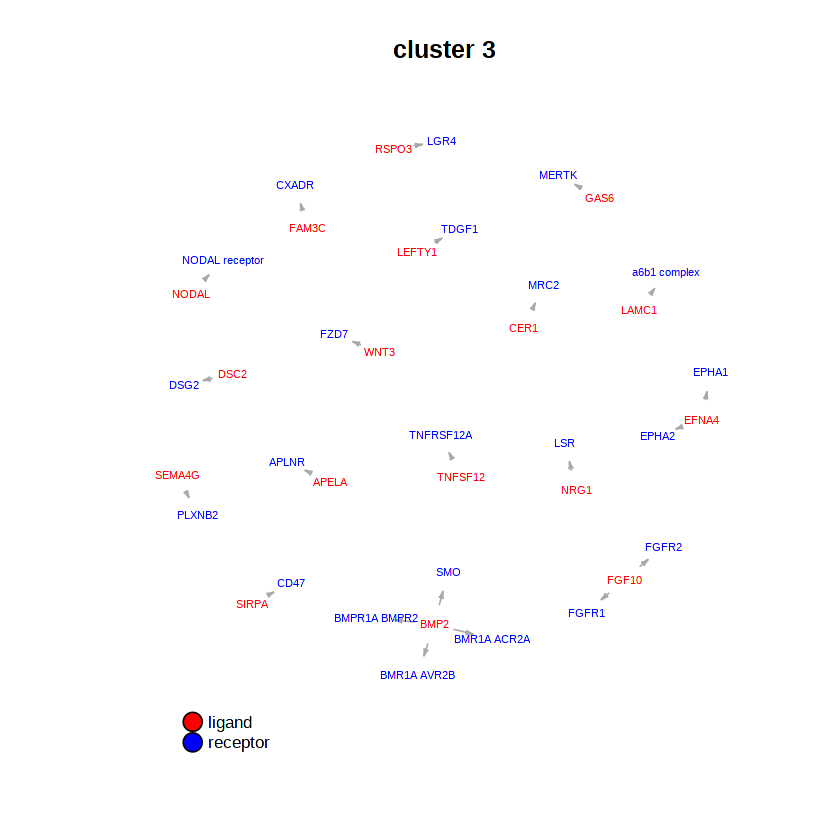

In [18]:
for(clusterNr in c(1:3)){
  plot_lig_rec(cluster_of_interest = clusterNr
               ,lrp_clusters = lrp_clusters$clusters
               ,ligand_receptor_pair_df = interactions$ligand_receptor_pair_df
               ,node_label_cex = 0.5
  )
}

Last updated: June 12,2021